# This notebook is to export bluesky scan data to simplied h5 data
* the exported h5 data typically contain keys, such as [ 'data', x_pixel_size', 'frame_time',
* 'pixel_mask', 'incident_wavelength', 'detector_distance', 
* 'y_pixel_size', 'beam_center_y', 'beam_center_x', 'count_time']

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events, get_fields
from eiger_io.pims_reader import EigerImages
import datetime
from filestore.path_only_handlers import RawHandler

import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages
from filestore.api import register_handler, deregister_handler



from chxtools import handlers
import scipy.misc
import numpy as np


def get_filenames(header):
    keys = [k for k, v in header.descriptors[0]['data_keys'].items()     if 'external' in v]
    events = get_events( header, keys, handler_overrides={key: RawHandler for key in keys})
    key, = keys
    unique_filenames = set([ev['data'][key][0] for ev in events])
    return unique_filenames

def get_sid_filenames(header):
    keys = [k for k, v in header.descriptors[0]['data_keys'].items()     if 'external' in v]
    events = get_events( header, keys, handler_overrides={key: RawHandler for key in keys})
    key, = keys
    #unique_filenames =  [ev['data'][key][0] for ev in events] 
    
    unique_filenames =  [  str( ev['data'][key][0]) + '_'+ str(ev['data'][key][2]['seq_id']) for ev in events] 
    
    sid = header['start']['scan_id']
    uid= header['start']['uid']
    return sid,uid, unique_filenames

def get_meta_data( filename ):
    '''add more keys in vals_dict if more metadata are required'''
    vals_dict =  {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
    }

    with h5py.File( filename + '_master.h5', 'r') as f:
        md = {k: f[v].value for k, v in vals_dict.items()}
    return md
    

def export_h5( imgs, md, filename):
    with h5py.File(filename, 'w') as f:    
        f['data'] =  imgs  
        if md is not None:
            for k in  list(md.keys()):
                f[k] =  md[k] 

def read_h5( filename):
    f = h5py.File( filename, 'r') 
    data = f['data']
    pixel_mask = f['pixel_mask']
    metadata={}
    for key in list(f.keys()):
        if (key!='pixel_mask') and (key!='data'):
            metadata[key] = f[key]    
    #f.close()
    return data, pixel_mask,metadata

def export_tif( imgs, filename ):
    scipy.misc.imsave( filename,  np.array( imgs ) )
    

def print_attrs( name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
        
        

def load_data( uid , detector = 'eiger4m_single_image'  ):
    """load bluesky scan data by giveing uid and detector
        
    Parameters
    ----------
    uid: unique ID of a bluesky scan
    detector: the used area detector
    
    Returns
    -------
    image data: a pims frames series
    if not success read the uid, will return image data as 0
    """   
    hdr = db[uid]
    flag =1
    while flag<4 and flag !=0:    
        try:
            ev, = get_events(hdr, [detector]) 
            flag =0 
        except:
            flag += 1        
            print ('Trying again ...!')

    if flag:
        print ("Can't Load Data!")
        uid = '00000'  #in case of failling load data
        imgs = 0
    else:
        imgs = ev['data'][detector]
    #print (imgs)
    return imgs

def show_img( image, *argv,**kwargs):    
    """a simple function to show image by using matplotlib.plt imshow
    pass *argv,**kwargs to imshow
    
    Parameters
    ----------
    image : array
        Image to show
    Returns
    -------
    None
    """ 
    
    fig, ax = plt.subplots()
    im=ax.imshow(image, origin='lower' ,cmap='viridis',interpolation="nearest",  *argv,**kwargs)  #vmin=0,vmax=1,
    fig.colorbar(im)
    plt.show()
    
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm    

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


In [2]:
%matplotlib notebook

In [3]:
detector = 'eiger4m_single_image'  #for 4m data
detector = 'eiger1m_single_image'  #for 1m data


## Give uid here

In [4]:
uid ='3a713ec3'

uid ='5c33348c'


# To get
*   scan id, which can be retrived from olog book https://logbook.nsls2.bnl.gov/11-ID/
*   uid, the unique id
*   filename with full path

In [5]:
sid, uid, name = get_sid_filenames( db[uid])

In [6]:
print (sid, uid,name)

12882 5c33348c-7edc-4d65-a08e-b9f5ef7f78d1 ['/XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226']


In [7]:
md = get_meta_data(   name[0]  )

## the metadata contains the following

In [8]:
md.keys()

dict_keys(['frame_time', 'beam_center_y', 'incident_wavelength', 'x_pixel_size', 'detector_distance', 'beam_center_x', 'pixel_mask', 'y_pixel_size', 'count_time'])

# get the image data

In [9]:
#imgs = load_data( uid , detector = 'eiger1m_single_image'  )

In [10]:
imgs = get_images( db[uid], detector)

hdf5 path = /XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226_master.h5


In [11]:
#imgs[0][0]

# show one image

hdf5 path = /XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226_master.h5


<IPython.core.display.Javascript object>


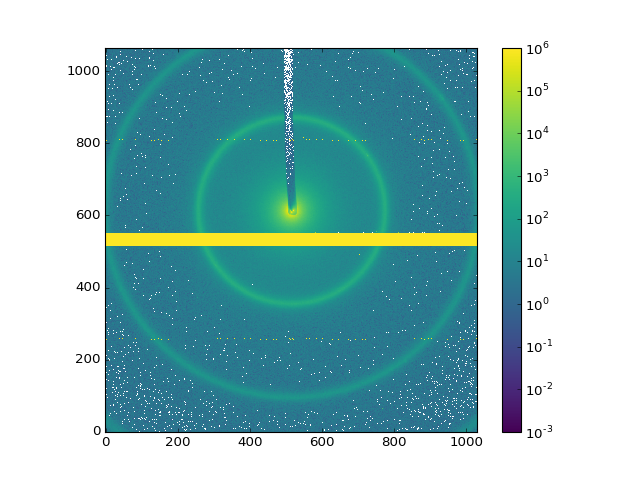

In [12]:
show_img( imgs[0][0],norm= LogNorm(vmin=0.001, vmax=1e6)) 

# Export images with meta data in path

In [13]:
path = '/XF11ID/analysis/2016_1/kennel/Horsehair_Export/'

In [14]:
export_h5( imgs, md, path + str(sid) +'_' +uid + '.h5' )

hdf5 path = /XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226_master.h5
hdf5 path = /XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226_master.h5
hdf5 path = /XF11ID/data/2016/03/23/8e5a3e3d-db4c-486f-9c8b_1226_master.h5


# Example to read data

In [15]:
data, pixel_mask, metadata = read_h5( path +   str(sid) +'_' +uid + '.h5')

In [16]:
data


<HDF5 dataset "data": shape (1, 1, 1065, 1030), type "<u4">

In [17]:
pixel_mask

<HDF5 dataset "pixel_mask": shape (1065, 1030), type "<u4">

In [18]:
metadata

{'beam_center_x': <HDF5 dataset "beam_center_x": shape (), type "<f4">,
 'beam_center_y': <HDF5 dataset "beam_center_y": shape (), type "<f4">,
 'count_time': <HDF5 dataset "count_time": shape (), type "<f4">,
 'detector_distance': <HDF5 dataset "detector_distance": shape (), type "<f4">,
 'frame_time': <HDF5 dataset "frame_time": shape (), type "<f4">,
 'incident_wavelength': <HDF5 dataset "incident_wavelength": shape (), type "<f4">,
 'x_pixel_size': <HDF5 dataset "x_pixel_size": shape (), type "<f4">,
 'y_pixel_size': <HDF5 dataset "y_pixel_size": shape (), type "<f4">}

In [19]:
metadata['x_pixel_size'].value

7.5000004e-05